In [1]:
import torch
import random

import numpy as np
import torch.nn as nn

from torchsummary import summary

import warnings
warnings.filterwarnings(action='ignore')

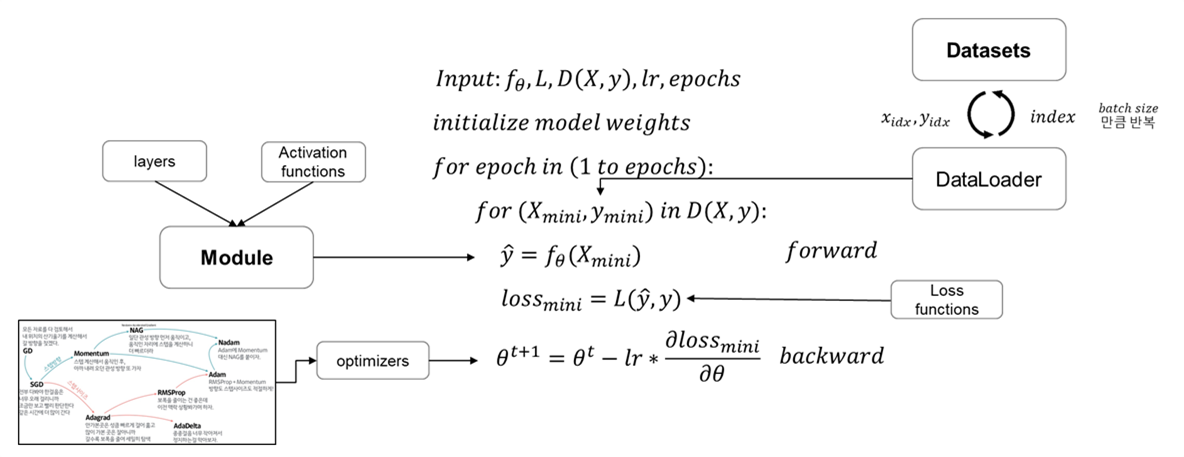

In [ ]:
# Local PC로 실습하는 경우 실행 x / 단 작업경로를 "LGES_240621"로 맞춰주기
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/LGES_240621

In [2]:
# 똑같은 결과를 얻기 위한 시드 고정
seed = 2024
torch.manual_seed(seed) # torch cpu seed 고정
torch.cuda.manual_seed(seed) # torch gpu seed 고정
torch.cuda.manual_seed_all(seed) # torch multi-gpu seed 고정
np.random.seed(seed) # numpy seed 고정
random.seed(seed) # python seed 고정

#### Dataset 및 DataLoader 정의

#### Random Augmentation
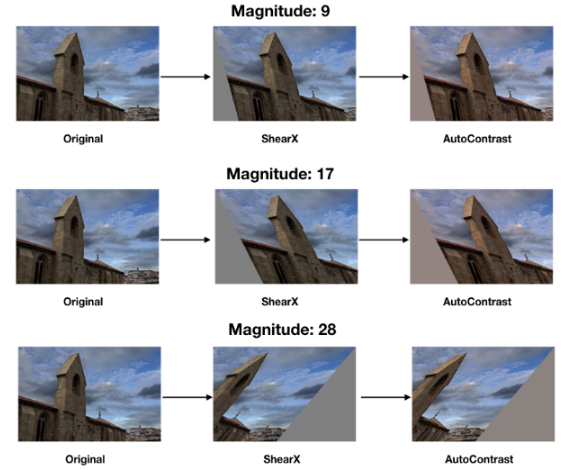

In [3]:
# CatDogDataset
from PIL import Image
from glob import glob
import torchvision.transforms as tf
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CatDogDataset(Dataset):
    def __init__(self, mode):
        # train 폴더 이미지 경로
        cat_train_path = glob(f'./data/dog_cat/train/cat/*') # train 폴더 cat 이미지 경로
        cat_train_labels = [0]*len(cat_train_path) # cat에 대한 레이블 생성

        dog_train_path = glob(f'./data/dog_cat/train/dog/*') # train 폴더 dog 이미지 경로
        dog_train_labels = [1]*len(dog_train_path) # dog에 대한 레이블 생성
        
        train_path = cat_train_path + dog_train_path
        train_labels = cat_train_labels + dog_train_labels
        
        # train/valid split
        train_path, valid_path, train_labels, valid_labels = train_test_split(train_path, train_labels, test_size=0.3, random_state=2024)
        
        # test 폴더 이미지 경로
        cat_test_path = glob(f'./data/dog_cat/test/cat/*')
        cat_test_labels = [0]*len(cat_test_path)

        dog_test_path = glob(f'./data/dog_cat/test/dog/*')
        dog_test_labels = [1]*len(dog_test_path)
        
        # testset을 위한 cat 이미지 + dog 이미지
        test_path = dog_test_path + cat_test_path
        test_labels = dog_test_labels + cat_test_labels
        
        if mode == 'train':
            self.img_path = train_path
            self.labels = train_labels
            self.transform = tf.Compose([
                                      # tf.ToPILImage(), 만약 데이터가 array나 tensor로 되어 있는 경우 PILImage로 변경이 필요
                                      tf.RandAugment(num_ops=2, magnitude=9),
                                      tf.Resize(size=(128,128)),
                                      tf.ToTensor()
                                      # tf.Normalize(mean=(0.0,0.0,0.0), std=(1.,1.,1.)), RGB의 평균과 분산을 알고 있는 경우 정규화
                                                    ])
        elif mode == 'valid':
            self.img_path = valid_path
            self.labels = valid_labels
            self.transform = tf.Compose([
                                      tf.Resize(size=(128,128)),
                                      tf.ToTensor(),
                                      # tf.Normalize(mean=(0.0,0.0,0.0), std=(1.,1.,1.))
                                      ])
        else:
            self.img_path = test_path
            self.labels = test_labels
            self.transform = tf.Compose([
                                      tf.Resize(size=(128,128)),
                                      tf.ToTensor(),
                                      # tf.Normalize(mean=(0.0,0.0,0.0), std=(1.,1.,1.))
                                      ])
    
    def __len__(self):
          return len(self.img_path)
        
    def __getitem__(self,idx):
          crt_img_path = self.img_path[idx] # 특정 이미지의 경로 선택
          img = Image.open(crt_img_path) # 이미지 오픈
          X = self.transform(img) # 이미지 변형
          
          y = self.labels[idx]
      
          return X, y

In [4]:
# 학습/테스트 데이터셋 및 데이터로더 생성
trainset = CatDogDataset(mode='train')

validset = CatDogDataset(mode='valid')

testset = CatDogDataset(mode='test')

trainloader = DataLoader(dataset=trainset, 
                         batch_size=64,
                         shuffle=True,
                         drop_last=True)

validloader = DataLoader(dataset=validset, 
                         batch_size=64,
                         shuffle=False,
                         drop_last=False)

testloader = DataLoader(dataset=testset, 
                         batch_size=64,
                         shuffle=False,
                         drop_last=False)

In [5]:
trainset.__getitem__(0)[0].shape

torch.Size([3, 128, 128])

In [16]:
print(f'trainset 이미지 수 : {len(trainset.img_path)}')
print(f'validset 이미지 수 : {len(validset.img_path)}')
print(f'testset 이미지 수  : {len(testset.img_path)}')

trainset 이미지 수 : 141
validset 이미지 수 : 61
testset 이미지 수  : 102


### 5-layer MLP를 통한 Cat&Dog 분류

In [6]:
class MyMLP(nn.Module):
    def __init__(self, num_classes=10):
        super(MyMLP, self).__init__()

        self.layer1 = nn.Sequential(
                            nn.Linear(3*128*128, 1024),
                            nn.BatchNorm1d(num_features=1024),
                            nn.ReLU(),
                            nn.Dropout1d(p=0.2))
        
        self.layer2 = nn.Sequential(
                            nn.Linear(1024, 256),
                            nn.BatchNorm1d(num_features=256),
                            nn.ReLU(),
                            nn.Dropout1d(p=0.2))
        
        self.layer3 = nn.Sequential(
                            nn.Linear(256, 128),
                            nn.BatchNorm1d(num_features=128),
                            nn.ReLU(),
                            nn.Dropout1d(p=0.2))
        
        self.layer4 = nn.Sequential(
                            nn.Linear(128, 64),
                            nn.BatchNorm1d(num_features=64),
                            nn.ReLU(),
                            nn.Dropout1d(p=0.2))
        
        self.layer5 = nn.Linear(64, num_classes)
        
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
        
        self.init_weights()
        
    def forward(self, x):
        # x : B, 3, 128, 128
        out = self.flatten(x) # B, 3*128*128
        out = self.layer1(out) # B, 1024
        out = self.layer2(out) # B, 256
        out = self.layer3(out) # B, 128
        out = self.layer4(out) # B, 64
        out = self.layer5(out) # B, 2
        
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

In [7]:
model = MyMLP(num_classes=2)
summary(model, input_size=(3,128,128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 49152]               0
            Linear-2                 [-1, 1024]      50,332,672
       BatchNorm1d-3                 [-1, 1024]           2,048
              ReLU-4                 [-1, 1024]               0
         Dropout1d-5                 [-1, 1024]               0
            Linear-6                  [-1, 256]         262,400
       BatchNorm1d-7                  [-1, 256]             512
              ReLU-8                  [-1, 256]               0
         Dropout1d-9                  [-1, 256]               0
           Linear-10                  [-1, 128]          32,896
      BatchNorm1d-11                  [-1, 128]             256
             ReLU-12                  [-1, 128]               0
        Dropout1d-13                  [-1, 128]               0
           Linear-14                   

#### Optimizer 정의

optimizer 종류 : https://pytorch.org/docs/stable/optim.html

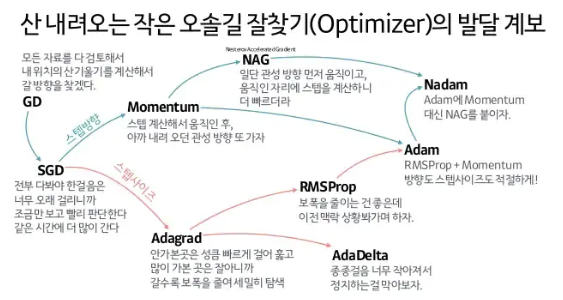

In [8]:
# loss.backward를 통해서 gradient를 계산하고 실제로 파라미터를 업데이트 하는 역할

sgd = torch.optim.SGD(params=model.parameters(), # 최적화 할 모델 파라미터
                      lr=0.01, # 학습률
                      momentum=0.9 # 과거 그레디언트 가중합 파라미터
                      # weight_decay=5e-4, l2 정규화 강도 파라미터
                      )

adam = torch.optim.Adam(params=model.parameters(), # 최적화 할 모델 파라미터
                      lr=0.01 # 학습률
                      # betas=(0.9,0.999) # (momentum, adaptive lr momentum)
                      # weight_decay=5e-4, l2 정규화 강도 파라미터
                      )

del sgd, adam

optimizer = torch.optim.Adam(params=model.parameters(),
                      lr=0.01,
                      betas=(0.9,0.999),
                      weight_decay=5e-4 # parameter값이 너무 커지지 않도록 규제 
                      )

#### Loss 함수 정의

loss function 종류 : https://pytorch.org/docs/stable/nn.html (검색 ->Loss functions)

In [9]:
mse_fn = nn.MSELoss()
nll_loss = nn.NLLLoss() # Negative log-likelihood loss
ce_fn = nn.CrossEntropyLoss()
bce_fn = nn.BCELoss() # Binary cross-entropy loss

del mse_fn, ce_fn, bce_fn

# 출력 노드를 2개로 했기 때문에 BCE loss를 쓰려면 shape을 따로 맞춰줘야 함
loss_fn = nn.CrossEntropyLoss() 

### To Device

In [10]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
# 모델 파라미터를 device로 이동
model.to(device)

# loss function을 device로 이동
loss_fn.to(device)

CrossEntropyLoss()

### 모델 학습

In [11]:
import time

epochs = 100
best_acc = 0.
train_history = {'loss':[],'acc':[]}
valid_history = {'loss':[],'acc':[]}

for epoch in range(epochs): # 학습 데이터셋 전체를 몇 번 학습시킬건지
    
    # epoch마다 학습이 어떻게 진행되는지 추적하기 위한 변수
    train_loss, valid_loss = 0.0, 0.0
    train_acc, valid_acc = 0.0, 0.0
    n_train, n_valid = 0, 0
    start = time.time()
    
    # training
    model.train() # batchnorm, dropout 등 train할 때와 test할 때 연산이 다른 경우가 존재
    for (imgs, targets) in trainloader: # 학습 데이터셋에서 batch size만큼 가져오기
        
        # 두 텐서를 모델, 목적함수와 같은 device로
        imgs = imgs.to(device) # B,3,32,32
        targets = targets.to(device) # B
        
        # forward
        outputs = model(imgs) # B,2
        
        # loss 계산
        loss = loss_fn(outputs, targets)
        
        # optimizer gradient 초기화
        optimizer.zero_grad()
        
        # backward : gradient 계산
        loss.backward()
        
        # model weight update
        optimizer.step()
        
        # loss 저장
        train_loss += loss.item()
        
        # 맞게 예측한 개수 및 배치 데이터 개수 저장
        preds = torch.max(outputs.detach(), dim=-1)[1] # B
        acc = torch.eq(preds,targets).sum().cpu().item()
        train_acc += acc
        n_train += targets.shape[0]
    
    # 현재 에폭 평균 학습 loss와 accuracy 계산
    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / n_train
    
    # validation : 에폭마다 validset으로 평가를 진행해 모델의 일반화 성능이 어느정도인지 확인
    model.eval() # batchnorm, dropout 등 train할 때와 test할 때 연산이 다른 경우가 존재
    with torch.no_grad():
        for (imgs, targets) in validloader:
            imgs = imgs.to(device) # B,3,32,32
            targets = targets.to(device) # B
            
            outputs = model(imgs) # B,2
            
            loss = loss_fn(outputs, targets)

            # loss 저장
            valid_loss += loss.item()
            
            # 정확도 저장
            preds = torch.max(outputs, dim=-1)[1] # B
            acc = torch.eq(preds,targets).sum().cpu().item()
            valid_acc += acc
            n_valid += targets.shape[0]
    
    # 현재 에폭 평균 테스트 loss와 accuracy 계산
    valid_loss = valid_loss / len(validloader)
    valid_acc = valid_acc / n_valid
    
    # best model일 경우 모델 저장
    if valid_acc > best_acc:
        best_acc = valid_acc
        best_epoch = epoch+1
        save_dict = {'model':model.state_dict(),
                     'optimizer':optimizer.state_dict(),
                     'epoch':best_epoch,
                     'acc':best_acc}
        torch.save(save_dict, './results/catdog_lenet.pt')
        
    # 학습/테스트에 소요된 시간 계산
    epoch_time = time.time() - start
    
    # 학습 정보 출력
    print(f'Epoch     : {epoch+1:6} | Time     : {epoch_time:.2f} sec')
    print(f'Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}')
    print(f'Train ACC : {train_acc:.4f} | Valid ACC : {valid_acc:.4f} \n')

    # 에폭별 학습 정보 저장
    train_history['loss'].append(train_loss)
    train_history['acc'].append(train_acc)
    valid_history['loss'].append(valid_loss)
    valid_history['acc'].append(valid_acc)


# 학습 종료
print('-'*50)
print('Dataset  : DogCat | Model : 5-layer MLP')
print(f'Best ACC : {best_acc:.4f} | Best Epoch : {best_epoch}')

Epoch     :      1 | Time     : 4.39 sec
Train Loss: 0.7470 | Valid Loss: 42.2673
Train ACC : 0.5547 | Valid ACC : 0.5574 

Epoch     :      2 | Time     : 0.40 sec
Train Loss: 0.7841 | Valid Loss: 31.3609
Train ACC : 0.5156 | Valid ACC : 0.5574 

Epoch     :      3 | Time     : 0.36 sec
Train Loss: 0.7630 | Valid Loss: 6.3211
Train ACC : 0.5547 | Valid ACC : 0.5410 

Epoch     :      4 | Time     : 0.38 sec
Train Loss: 0.7232 | Valid Loss: 5.9890
Train ACC : 0.5078 | Valid ACC : 0.4426 

Epoch     :      5 | Time     : 0.38 sec
Train Loss: 0.7429 | Valid Loss: 1.0694
Train ACC : 0.5547 | Valid ACC : 0.4262 

Epoch     :      6 | Time     : 0.40 sec
Train Loss: 0.7075 | Valid Loss: 2.2778
Train ACC : 0.5312 | Valid ACC : 0.5574 

Epoch     :      7 | Time     : 0.38 sec
Train Loss: 0.7364 | Valid Loss: 1.5148
Train ACC : 0.5234 | Valid ACC : 0.5410 

Epoch     :      8 | Time     : 0.38 sec
Train Loss: 0.7040 | Valid Loss: 0.9083
Train ACC : 0.5781 | Valid ACC : 0.5410 

Epoch     :   

### 모델 학습 추세 시각화

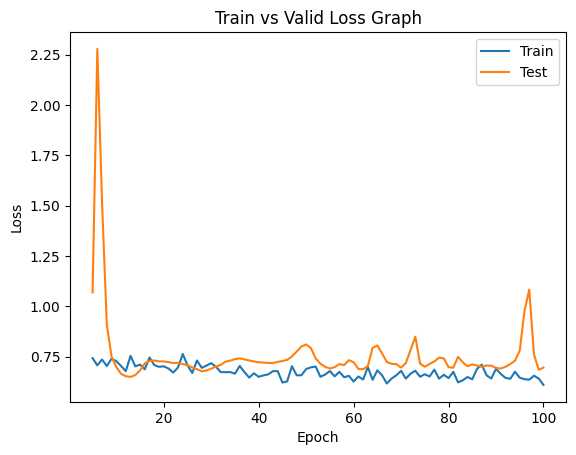

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=range(5,epochs+1),y=train_history['loss'][4:], label='Train')
sns.lineplot(x=range(5,epochs+1),y=valid_history['loss'][4:], label='Test')
plt.title('Train vs Valid Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

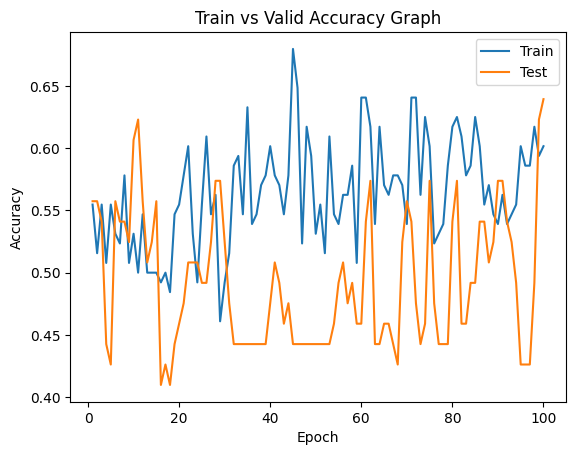

In [13]:
sns.lineplot(x=range(1,epochs+1),y=train_history['acc'], label='Train')
sns.lineplot(x=range(1,epochs+1),y=valid_history['acc'], label='Test')
plt.title('Train vs Valid Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

### Testset을 통한 최종 모델 성능평가

In [14]:
# 저장된 모델 load / 모델 구조를 불러온 뒤 parameter를 해당 레이어로 load해줘야함
test_model = MyMLP(num_classes=2) # 모델 구조 선억
load_dict = torch.load('./results/catdog_lenet.pt', map_location='cpu')
parameters = load_dict['model'] 
test_model.load_state_dict(parameters,strict=False)

# to device
test_model.to(device)

MyMLP(
  (layer1): Sequential(
    (0): Linear(in_features=49152, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout1d(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout1d(p=0.2, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout1d(p=0.2, inplace=False)
  )
  (layer4): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout1d(p=0.2, inplace=False)
  )
  (layer5): Linear(in_features=64, out_fea

In [15]:
# test
test_acc = 0.0
n_test = 0
model.eval()
with torch.no_grad():
    for (imgs, targets) in testloader:
        imgs = imgs.to(device) # B,3,32,32
        targets = targets.to(device) # B
        
        outputs = model(imgs) # B,2
        
        # max함수를 통한 예측값 생성
        preds = torch.max(outputs, dim=-1)[1] # B
        acc = torch.eq(preds,targets).sum().cpu().item()
        test_acc += acc
        n_test += targets.shape[0]

# accuracy 계산
test_acc = test_acc / n_test

# 학습 정보 출력
print(f'Data      : dog_cat')
print(f'Seed      : {seed}')
print(f'Model     : LeNet5')
print(f'valid ACC : {load_dict["acc"]:.4f}')
print(f'test ACC  : {test_acc:.4f} \n')

Data      : dog_cat
Seed      : 2024
Model     : LeNet5
valid ACC : 0.6393
test ACC  : 0.5196 



#### CNN을 통한 Cat&Dog 분류: LeNet5을 고해상도 이미지에 맞게 좀 더 깊게 변형

kernel size를 줄이면 파라미터 효율이 좋아지고 깊은 모델을 만들 수 있음

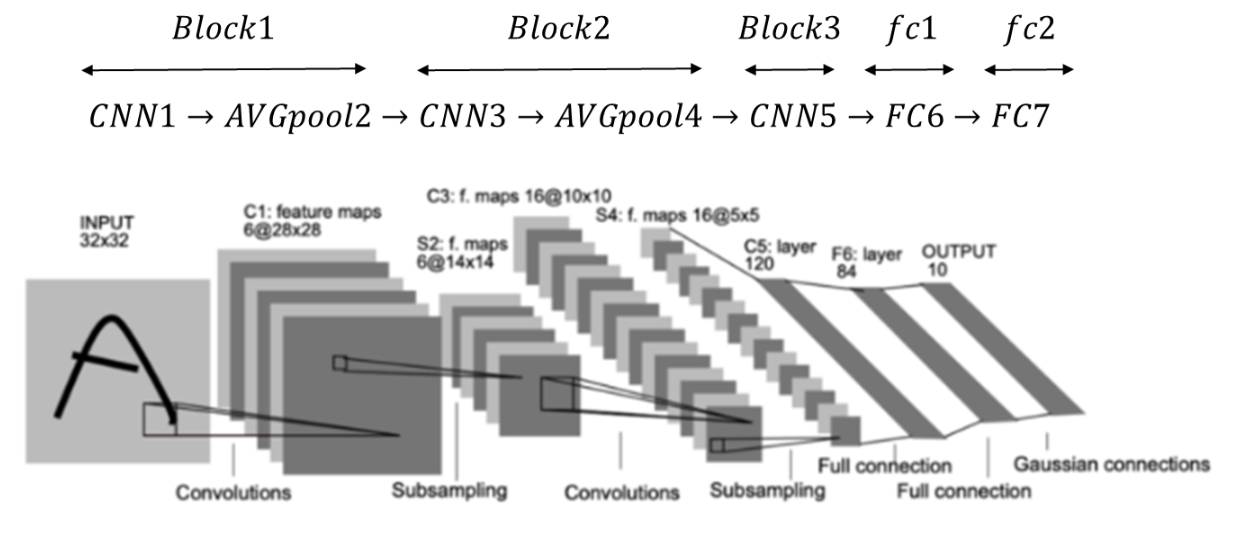

#### receptive field of CNNs
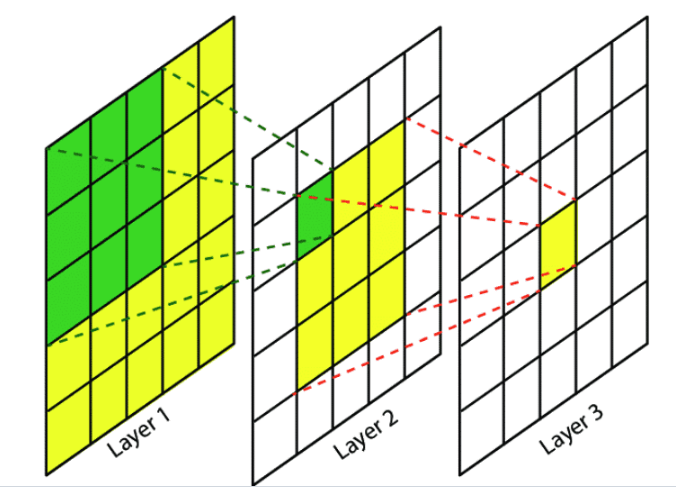

In [5]:
class MyLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MyLeNet, self).__init__()

        self.block1 = nn.Sequential(
                           nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
                           nn.BatchNorm2d(num_features=16),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0)))
        
        self.block2 = nn.Sequential(
                           nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
                           nn.BatchNorm2d(num_features=32),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0)))
        
        self.block3 = nn.Sequential(
                            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
                            nn.BatchNorm2d(num_features=64),
                            nn.ReLU(),
                           nn.MaxPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0)))
        
        self.block4 = nn.Sequential(
                            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
                            nn.BatchNorm2d(num_features=128),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0)))
        
        self.block5 = nn.Sequential(
                            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
                            nn.BatchNorm2d(num_features=128),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0)))
        
        self.fc1 = nn.Sequential(nn.Linear(128*4*4,128), nn.ReLU())
        self.fc2 = nn.Linear(128,num_classes)
        
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
        
        self.init_weights()
        
    def forward(self, x):
        # x : B, 3, 128, 128
        out = self.block1(x) # B, 16, 64, 64
        out = self.block2(out) # B, 32, 32, 32
        out = self.block3(out) # B, 64, 16, 16
        out = self.block4(out) # B, 128, 8, 8
        out = self.block5(out) # B, 128, 4, 4
        out = self.flatten(out) # B, 128*4*4
        out = self.fc1(out) # B, 128
        out = self.fc2(out) # B, num_classes
        
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

In [6]:
model = MyLeNet(num_classes=2)
summary(model, input_size=(3,128,128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
         MaxPool2d-4           [-1, 16, 64, 64]               0
            Conv2d-5           [-1, 32, 64, 64]           4,640
       BatchNorm2d-6           [-1, 32, 64, 64]              64
              ReLU-7           [-1, 32, 64, 64]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,496
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
        MaxPool2d-12           [-1, 64, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]          73,856
      BatchNorm2d-14          [-1, 128,

#### Optimizer 정의

optimizer 종류 : https://pytorch.org/docs/stable/optim.html

In [7]:
# loss.backward를 통해서 gradient를 계산하고 실제로 파라미터를 업데이트 하는 역할

sgd = torch.optim.SGD(params=model.parameters(), # 최적화 할 모델 파라미터
                      lr=0.01, # 학습률
                      momentum=0.9 # 과거 그레디언트 가중합 파라미터
                      # weight_decay=5e-4, l2 정규화 강도 파라미터
                      )

adam = torch.optim.Adam(params=model.parameters(), # 최적화 할 모델 파라미터
                      lr=0.01 # 학습률
                      # betas=(0.9,0.999) # (momentum, adaptive lr momentum)
                      # weight_decay=5e-4, l2 정규화 강도 파라미터
                      )

del sgd, adam

optimizer = torch.optim.SGD(params=model.parameters(),
                      lr=0.001,
                      momentum=0.9,
                      weight_decay=5e-4 # parameter값이 너무 커지지 않도록 규제 
                      )

#### Loss 함수 정의

loss function 종류 : https://pytorch.org/docs/stable/nn.html (검색 ->Loss functions)

In [8]:
mse_fn = nn.MSELoss()
nll_loss = nn.NLLLoss() # Negative log-likelihood loss
ce_fn = nn.CrossEntropyLoss()
bce_fn = nn.BCELoss() # Binary cross-entropy loss

del mse_fn, ce_fn, bce_fn

# 출력 노드를 2개로 했기 때문에 BCE loss를 쓰려면 shape을 따로 맞춰줘야 함
loss_fn = nn.CrossEntropyLoss() 

#### To Device

In [9]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
# 모델 파라미터를 device로 이동
model.to(device)

# loss function을 device로 이동
loss_fn.to(device)

CrossEntropyLoss()

#### 역전파 알고리즘

In [10]:
import time

epochs = 100
best_acc = 0.
train_history = {'loss':[],'acc':[]}
valid_history = {'loss':[],'acc':[]}

for epoch in range(epochs): # 학습 데이터셋 전체를 몇 번 학습시킬건지
    
    # epoch마다 학습이 어떻게 진행되는지 추적하기 위한 변수
    train_loss, valid_loss = 0.0, 0.0
    train_acc, valid_acc = 0.0, 0.0
    n_train, n_valid = 0, 0
    start = time.time()
    
    # training
    model.train() # batchnorm, dropout 등 train할 때와 test할 때 연산이 다른 경우가 존재
    for (imgs, targets) in trainloader: # 학습 데이터셋에서 batch size만큼 가져오기
        
        # 두 텐서를 모델, 목적함수와 같은 device로
        imgs = imgs.to(device) # B,3,32,32
        targets = targets.to(device) # B
        
        # forward
        outputs = model(imgs) # B,2
        
        # loss 계산
        loss = loss_fn(outputs, targets)
        
        # optimizer gradient 초기화
        optimizer.zero_grad()
        
        # backward : gradient 계산
        loss.backward()
        
        # model weight update
        optimizer.step()
        
        # loss 저장
        train_loss += loss.item()
        
        # 맞게 예측한 개수 및 배치 데이터 개수 저장
        preds = torch.max(outputs.detach(), dim=-1)[1] # B
        acc = torch.eq(preds,targets).sum().cpu().item()
        train_acc += acc
        n_train += targets.shape[0]
    
    # 현재 에폭 평균 학습 loss와 accuracy 계산
    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / n_train
    
    # validation : 에폭마다 validset으로 평가를 진행해 모델의 일반화 성능이 어느정도인지 확인
    model.eval() # batchnorm, dropout 등 train할 때와 test할 때 연산이 다른 경우가 존재
    with torch.no_grad():
        for (imgs, targets) in validloader:
            imgs = imgs.to(device) # B,3,32,32
            targets = targets.to(device) # B
            
            outputs = model(imgs) # B,2
            
            loss = loss_fn(outputs, targets)

            # loss 저장
            valid_loss += loss.item()
            
            # 정확도 저장
            preds = torch.max(outputs, dim=-1)[1] # B
            acc = torch.eq(preds,targets).sum().cpu().item()
            valid_acc += acc
            n_valid += targets.shape[0]
    
    # 현재 에폭 평균 테스트 loss와 accuracy 계산
    valid_loss = valid_loss / len(validloader)
    valid_acc = valid_acc / n_valid
    
    # best model일 경우 모델 저장
    if valid_acc > best_acc:
        best_acc = valid_acc
        best_epoch = epoch+1
        save_dict = {'model':model.state_dict(),
                     'optimizer':optimizer.state_dict(),
                     'epoch':best_epoch,
                     'acc':best_acc}
        torch.save(save_dict, './results/catdog_lenet.pt')
        
    # 학습/테스트에 소요된 시간 계산
    epoch_time = time.time() - start
    
    # 학습 정보 출력
    print(f'Epoch     : {epoch+1:6} | Time     : {epoch_time:.2f} sec')
    print(f'Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}')
    print(f'Train ACC : {train_acc:.4f} | Valid ACC : {valid_acc:.4f} \n')

    # 에폭별 학습 정보 저장
    train_history['loss'].append(train_loss)
    train_history['acc'].append(train_acc)
    valid_history['loss'].append(valid_loss)
    valid_history['acc'].append(valid_acc)


# 학습 종료
print('-'*50)
print('Dataset  : DogCat | Model : LeNet5')
print(f'Best ACC : {best_acc:.4f} | Best Epoch : {best_epoch}')
    

Epoch     :      1 | Time     : 2.36 sec
Train Loss: 0.7532 | Valid Loss: 0.6902
Train ACC : 0.5625 | Valid ACC : 0.6230 

Epoch     :      2 | Time     : 0.37 sec
Train Loss: 0.6832 | Valid Loss: 0.6868
Train ACC : 0.6562 | Valid ACC : 0.5246 

Epoch     :      3 | Time     : 0.35 sec
Train Loss: 0.7109 | Valid Loss: 0.6844
Train ACC : 0.5781 | Valid ACC : 0.5574 

Epoch     :      4 | Time     : 0.35 sec
Train Loss: 0.7246 | Valid Loss: 0.6885
Train ACC : 0.5781 | Valid ACC : 0.5574 

Epoch     :      5 | Time     : 0.35 sec
Train Loss: 0.7145 | Valid Loss: 0.6906
Train ACC : 0.5938 | Valid ACC : 0.5574 

Epoch     :      6 | Time     : 0.36 sec
Train Loss: 0.6370 | Valid Loss: 0.6840
Train ACC : 0.6797 | Valid ACC : 0.5410 

Epoch     :      7 | Time     : 0.37 sec
Train Loss: 0.6252 | Valid Loss: 0.6825
Train ACC : 0.6797 | Valid ACC : 0.5410 

Epoch     :      8 | Time     : 0.37 sec
Train Loss: 0.6419 | Valid Loss: 0.6876
Train ACC : 0.6641 | Valid ACC : 0.5410 

Epoch     :     

#### 학습 추세 시각화

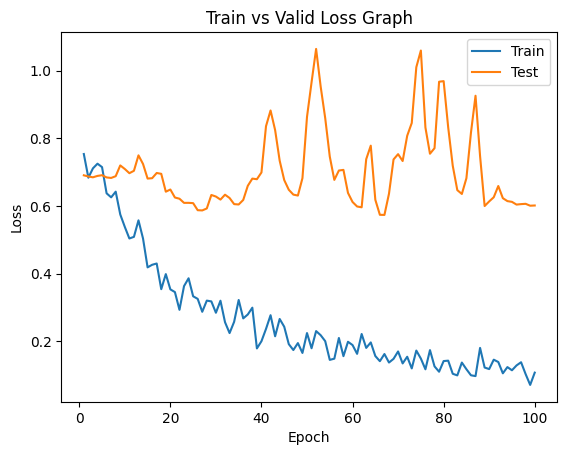

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=range(1,epochs+1),y=train_history['loss'], label='Train')
sns.lineplot(x=range(1,epochs+1),y=valid_history['loss'], label='Test')
plt.title('Train vs Valid Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

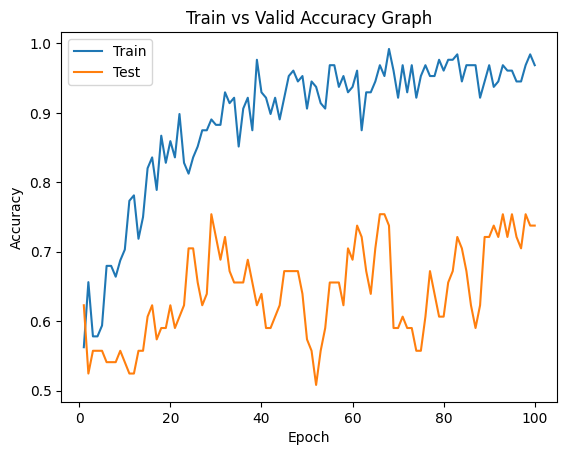

In [12]:
sns.lineplot(x=range(1,epochs+1),y=train_history['acc'], label='Train')
sns.lineplot(x=range(1,epochs+1),y=valid_history['acc'], label='Test')
plt.title('Train vs Valid Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#### Testset을 통한 최종 모델 성능평가

In [13]:
# 저장된 모델 load / 모델 구조를 불러온 뒤 parameter를 해당 레이어로 load해줘야함
test_model = MyLeNet(num_classes=2) # 모델 구조 선억
load_dict = torch.load('./results/catdog_lenet.pt', map_location='cpu')
parameters = load_dict['model'] 
test_model.load_state_dict(parameters,strict=False)

# to device
test_model.to(device)

MyLeNet(
  (block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), st

In [14]:
# test
test_acc = 0.0
n_test = 0
model.eval()
with torch.no_grad():
    for (imgs, targets) in testloader:
        imgs = imgs.to(device) # B,3,32,32
        targets = targets.to(device) # B
        
        outputs = model(imgs) # B,2
        
        # max함수를 통한 예측값 생성
        preds = torch.max(outputs, dim=-1)[1] # B
        acc = torch.eq(preds,targets).sum().cpu().item()
        test_acc += acc
        n_test += targets.shape[0]

# accuracy 계산
test_acc = test_acc / n_test

# 학습 정보 출력
print(f'Data      : dog_cat')
print(f'Seed      : {seed}')
print(f'Model     : LeNet5')
print(f'valid ACC : {load_dict["acc"]:.4f}')
print(f'test ACC  : {test_acc:.4f} \n')


Data      : dog_cat
Seed      : 2024
Model     : LeNet5
valid ACC : 0.7541
test ACC  : 0.6569 

